# Captone Project: Generate Title and category

**Overview**: In this practical application,



## Business understanding of the problem
The objective is to classify whether a customer will subscribe to a term deposit (y variable: yes/no) based on their characteristics and campaign attributes.
This will help the bank optimize marketing strategies and improve customer targeting.

### Getting Started

Our dataset comes from the UCI Machine Learning repository [link](https://archive.ics.uci.edu/ml/datasets/bank+marketing).  The data is from a Portugese banking institution and is a collection of the results of multiple marketing campaigns.  We will make use of the article accompanying the dataset [here](CRISP-DM-BANK.pdf) for more information on the data and features.



#### Data task
The task is to identify and quantify the key factors that influence the price of used cars. This involves analyzing the relationships between car attributes (e.g., manufacturer, year, mileage, fuel type, condition) and the target variable, price. The goal is to build a predictive model to estimate car prices based on these features, evaluate the impact of each feature using statistical and machine learning techniques, and provide actionable insights to optimize inventory and pricing strategies for the dealership.



### Data Understanding

After considering the business understanding, we want to get familiar with our data.  Write down some steps that you would take to get to know the dataset and identify any quality issues within.  Take time to get to know the dataset and explore what information it contains and how this could be used to inform your business understanding.

In [1188]:
import pandas as pd
import numpy as np
from pathlib import Path

In [439]:
#### 1. Read in the styles.csv file.

In [1190]:
df = pd.read_csv('fashion-dataset/fashion-dataset/styles.csv', delimiter=';')

In [1192]:
df.head()

,id,gender,masterCategory,subCategory,articleType,baseColour,season,year,usage,productDisplayName
0,15970,Men,Apparel,Topwear,Shirts,Navy Blue,Fall,2011,Casual,Turtle Check Men Navy Blue Shirt
1,39386,Men,Apparel,Bottomwear,Jeans,Blue,Summer,2012,Casual,Peter England Men Party Blue Jeans
2,59263,Women,Accessories,Watches,Watches,Silver,Winter,2016,Casual,Titan Women Silver Watch
3,21379,Men,Apparel,Bottomwear,Track Pants,Black,Fall,2011,Casual,Manchester United Men Solid Black Track Pants
4,53759,Men,Apparel,Topwear,Tshirts,Grey,Summer,2012,Casual,Puma Men Grey T-shirt


#### 2. Investigate the dataset for missing or problematic data


In [1194]:
# checking counts and data type for each column
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 82846 entries, 0 to 82845
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   id                  82846 non-null  int64 
 1   gender              82846 non-null  object
 2   masterCategory      82846 non-null  object
 3   subCategory         82846 non-null  object
 4   articleType         82846 non-null  object
 5   baseColour          82846 non-null  object
 6   season              82846 non-null  object
 7   year                82846 non-null  int64 
 8   usage               82846 non-null  object
 9   productDisplayName  82846 non-null  object
dtypes: int64(2), object(8)
memory usage: 6.3+ MB
None


In [1196]:
print(df.columns)

Index(['id', 'gender', 'masterCategory', 'subCategory', 'articleType',
       'baseColour', 'season', 'year', 'usage', 'productDisplayName'],
      dtype='object')


In [1198]:
# data count
print(df.shape)

(82846, 10)


In [1200]:
df.describe(include='all')

,id,gender,masterCategory,subCategory,articleType,baseColour,season,year,usage,productDisplayName
count,82846.000000,82846,82846,82846,82846,82846,82846,82846.000000,82846,82846
unique,NaN,5,7,45,143,47,4,NaN,8,31147
top,NaN,Men,Apparel,Topwear,Tshirts,Black,Summer,NaN,Casual,Lucera Women Silver Earrings
freq,NaN,41390,39971,28821,13231,18157,40096,NaN,64687,156
mean,29677.801644,NaN,NaN,NaN,NaN,NaN,NaN,2012.804034,NaN,NaN
std,17044.387615,NaN,NaN,NaN,NaN,NaN,NaN,2.125836,NaN,NaN
min,1163.000000,NaN,NaN,NaN,NaN,NaN,NaN,2007.000000,NaN,NaN
25%,14762.000000,NaN,NaN,NaN,NaN,NaN,NaN,2011.000000,NaN,NaN
50%,28595.000000,NaN,NaN,NaN,NaN,NaN,NaN,2012.000000,NaN,NaN
75%,44661.750000,NaN,NaN,NaN,NaN,NaN,NaN,2015.000000,NaN,NaN


In [1202]:
print(df.columns)

Index(['id', 'gender', 'masterCategory', 'subCategory', 'articleType',
       'baseColour', 'season', 'year', 'usage', 'productDisplayName'],
      dtype='object')


In [1204]:
# checking for the presence of null values
missing_vals = df.isnull().sum()


print(type(missing_vals))
missing_vals


<class 'pandas.core.series.Series'>


id                    0
gender                0
masterCategory        0
subCategory           0
articleType           0
baseColour            0
season                0
year                  0
usage                 0
productDisplayName    0
dtype: int64

In [1206]:
df.dropna(inplace=True)

In [1208]:
# checking for the presence of null values again
missing_vals = df.isnull().sum()

print(type(missing_vals))
missing_vals

<class 'pandas.core.series.Series'>


id                    0
gender                0
masterCategory        0
subCategory           0
articleType           0
baseColour            0
season                0
year                  0
usage                 0
productDisplayName    0
dtype: int64

In [1210]:
# checking for duplicate values
duplicate_values = df['id'].duplicated().sum()

print(type(duplicate_values))
duplicate_values

<class 'numpy.int64'>


38400

In [1212]:
# remove duplicates
df = df.drop_duplicates(subset='id', keep='first')

In [1214]:
# checking for duplicate values again
duplicate_values = df['id'].duplicated().sum()

print(type(duplicate_values))
duplicate_values

<class 'numpy.int64'>


0

In [1234]:
# checking the percentage of the presence of null values
print((df.isnull().sum() / len(df)) * 100)

id                    0.0
gender                0.0
masterCategory        0.0
subCategory           0.0
articleType           0.0
baseColour            0.0
season                0.0
year                  0.0
usage                 0.0
productDisplayName    0.0
dtype: float64


In [1236]:
#checking image exist in the path


img_dir = Path('fashion-dataset/fashion-dataset/images')

missing = df[~df['id'].astype(str).apply(lambda x: ( img_dir/f"{x}.jpg").exists() )]



print(f'Missing images: {len(missing)}')

Missing images: 0


In [1238]:
df = df.drop(missing.index).reset_index(drop=True)

In [1240]:
#checking image exist in the path again


img_dir = Path('fashion-dataset/fashion-dataset/images')

missing = df[~df['id'].astype(str).apply(lambda x: ( img_dir/f"{x}.jpg").exists() )]

print(f'Missing images: {len(missing)}')

Missing images: 0


In [1242]:
# lets get the list of numerical and categorical columns
column_names = df.columns.tolist()

column_names

['id',
 'gender',
 'masterCategory',
 'subCategory',
 'articleType',
 'baseColour',
 'season',
 'year',
 'usage',
 'productDisplayName']

In [1244]:
# Summary for numerical columns
print(df.describe()) 

                 id          year
count  44441.000000  44441.000000
mean   29692.147049   2012.805832
std    17048.746205      2.126403
min     1163.000000   2007.000000
25%    14770.000000   2011.000000
50%    28608.000000   2012.000000
75%    44680.000000   2015.000000
max    60000.000000   2019.000000


In [1246]:
# Summary for categorical columns
print(df.describe(include=['object']))  

       gender masterCategory subCategory articleType baseColour  season  \
count   44441          44441       44441       44441      44441   44441   
unique      5              7          45         142         47       4   
top       Men        Apparel     Topwear     Tshirts      Black  Summer   
freq    22160          21395       15401        7069       9731   21495   

         usage            productDisplayName  
count    44441                         44441  
unique       8                         31132  
top     Casual  Lucera Women Silver Earrings  
freq     34726                            82  


In [1252]:
# split the columns into numerical and categorical columns
numerical_columns = df.select_dtypes(include=['int64', 'float64']).columns
categorical_columns = df.select_dtypes(include=['object']).columns
print('Numerical ---> ')
print(numerical_columns)
print('Categorical ---> ')
print(categorical_columns)

Numerical ---> 
Index(['id', 'year'], dtype='object')
Categorical ---> 
Index(['gender', 'masterCategory', 'subCategory', 'articleType', 'baseColour',
       'season', 'usage', 'productDisplayName'],
      dtype='object')


In [1254]:
# for all the categorical columns, we can see the unique values
for col in df.select_dtypes(include='object').columns:
    print(f'{col}: {df[col].unique()}')

gender: ['Men' 'Women' 'Boys' 'Girls' 'Unisex']
masterCategory: ['Apparel' 'Accessories' 'Footwear' 'Personal Care' 'Free Items'
 'Sporting Goods' 'Home']
subCategory: ['Topwear' 'Bottomwear' 'Watches' 'Socks' 'Shoes' 'Belts' 'Flip Flops'
 'Bags' 'Innerwear' 'Sandal' 'Shoe Accessories' 'Fragrance' 'Jewellery'
 'Lips' 'Saree' 'Eyewear' 'Nails' 'Scarves' 'Dress'
 'Loungewear and Nightwear' 'Wallets' 'Apparel Set' 'Headwear' 'Mufflers'
 'Skin Care' 'Makeup' 'Free Gifts' 'Ties' 'Accessories' 'Skin'
 'Beauty Accessories' 'Water Bottle' 'Eyes' 'Bath and Body' 'Gloves'
 'Sports Accessories' 'Cufflinks' 'Sports Equipment' 'Stoles' 'Hair'
 'Perfumes' 'Home Furnishing' 'Umbrellas' 'Wristbands' 'Vouchers']
articleType: ['Shirts' 'Jeans' 'Watches' 'Track Pants' 'Tshirts' 'Socks' 'Casual Shoes'
 'Belts' 'Flip Flops' 'Handbags' 'Tops' 'Bra' 'Sandals' 'Shoe Accessories'
 'Sweatshirts' 'Deodorant' 'Formal Shoes' 'Bracelet' 'Lipstick' 'Flats'
 'Kurtas' 'Waistcoat' 'Sports Shoes' 'Shorts' 'Briefs' 'Sare

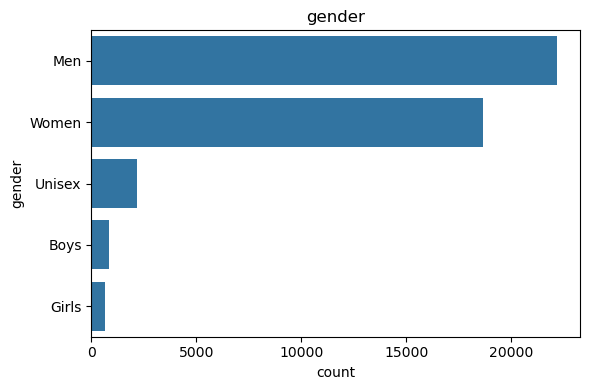

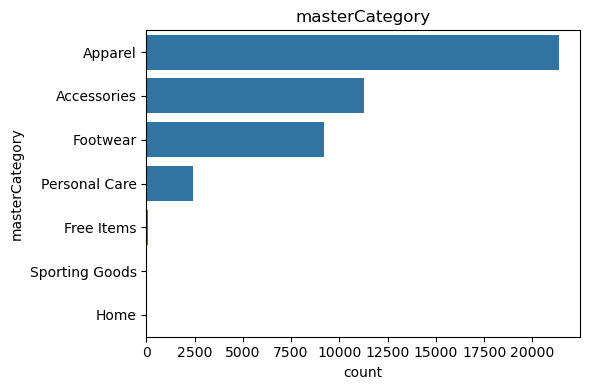

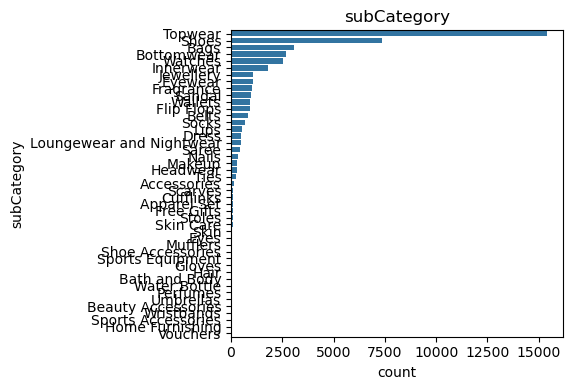

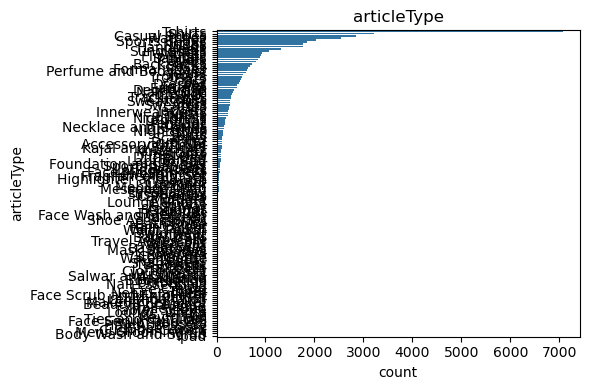

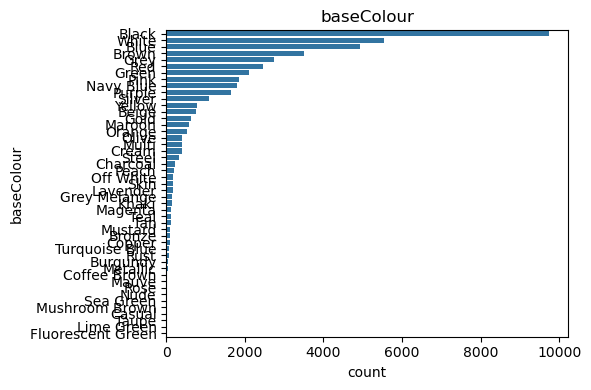

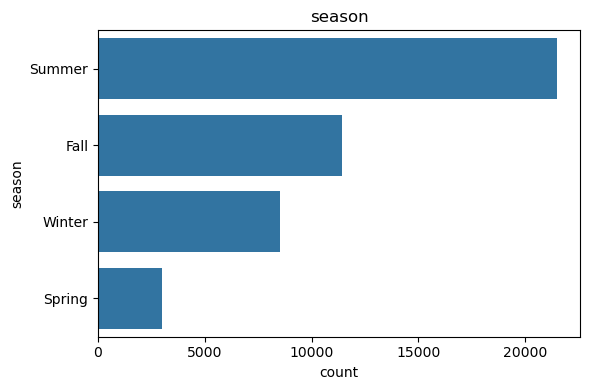

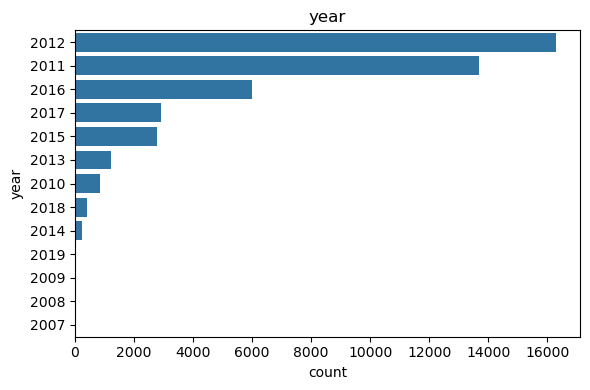

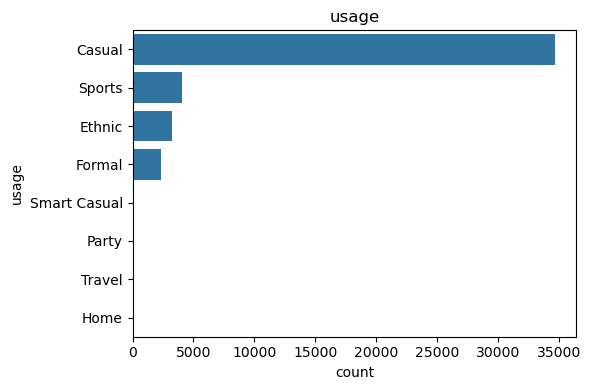

/var/folders/ql/ssl6mf497ls4_dvq3891h2_c0000gn/T/ipykernel_32457/394174006.py:15: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


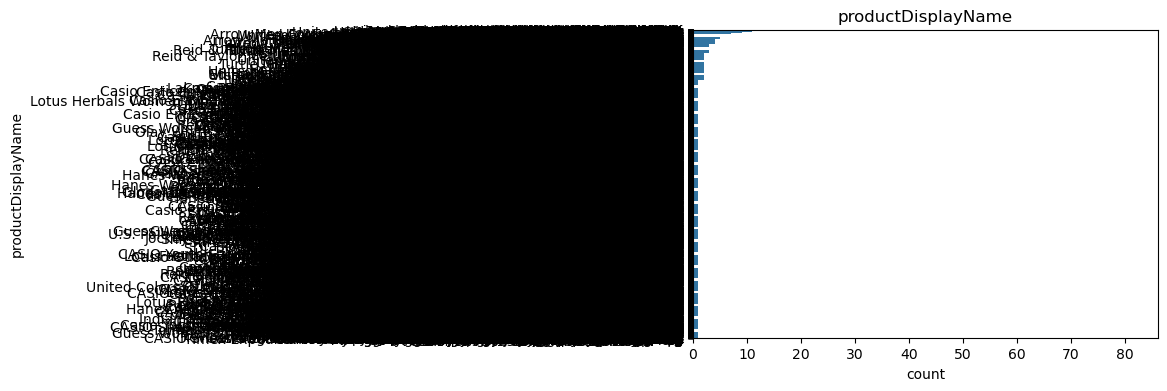

In [1256]:
## Deep dive into data, understand the data distribution and relationships

import matplotlib.pyplot as plt
import seaborn as sns

# Split the features into numerical and categorical
numerical_features = ['id', 'year']
categorical_features = ['gender','masterCategory','subCategory','articleType','baseColour','season','year','usage','productDisplayName']


for c in categorical_features:
    plt.figure(figsize=(6,4))
    sns.countplot(data=df, y=c, order=df[c].value_counts().index)
    plt.title(c)
    plt.tight_layout()
    plt.show()



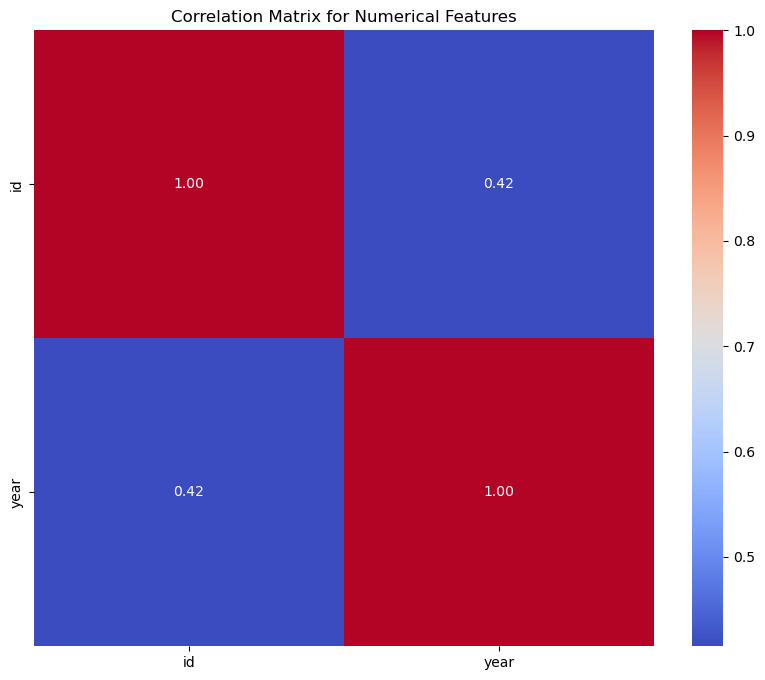

,id,year
id,1.000000,0.415123
year,0.415123,1.000000


In [1260]:
# Calculate correlations for numerical features
correlation_matrix = df[numerical_features].corr()

# Plot the correlation matrix
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f", cbar=True)
plt.title("Correlation Matrix for Numerical Features")
plt.show()

correlation_matrix

In [1264]:
# Display the final set of data after cleaning
print(df.shape),
print(df.info())
print(df.isnull().sum())
print(df.describe())
print(df.describe(include=['object']))
print(df.head())

(44441, 10)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 44441 entries, 0 to 44440
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   id                  44441 non-null  int64 
 1   gender              44441 non-null  object
 2   masterCategory      44441 non-null  object
 3   subCategory         44441 non-null  object
 4   articleType         44441 non-null  object
 5   baseColour          44441 non-null  object
 6   season              44441 non-null  object
 7   year                44441 non-null  int64 
 8   usage               44441 non-null  object
 9   productDisplayName  44441 non-null  object
dtypes: int64(2), object(8)
memory usage: 3.4+ MB
None
id                    0
gender                0
masterCategory        0
subCategory           0
articleType           0
baseColour            0
season                0
year                  0
usage                 0
productDisplayName    0
dtype: i

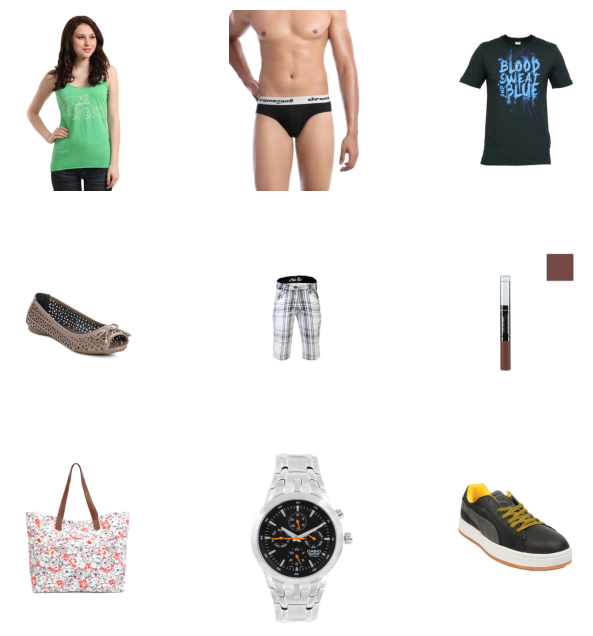

In [1266]:
from PIL import Image
import random

sample = random.sample(df['id'].tolist(), 9)
plt.figure(figsize=(8,8))
for i, pid in enumerate(sample):
    img = Image.open(img_dir/f"{pid}.jpg")
    plt.subplot(3,3,i+1)
    plt.imshow(img)
    plt.axis('off')
plt.show()

#### Exploratory Data Analysis (EDA)

In [1268]:
import matplotlib.pyplot as plt
import seaborn as sns

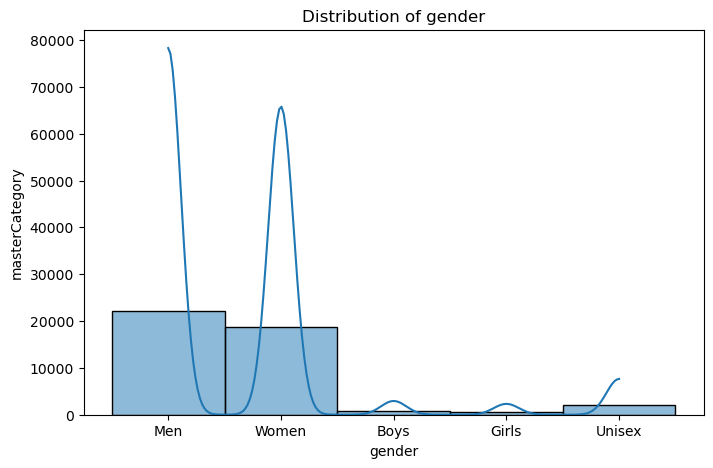

In [1270]:
# Distribution of Price
plt.figure(figsize=(8, 5))
sns.histplot(df['gender'], bins=30, kde=True)
plt.title('Distribution of gender')
plt.xlabel('gender')
plt.ylabel('masterCategory')
plt.show()

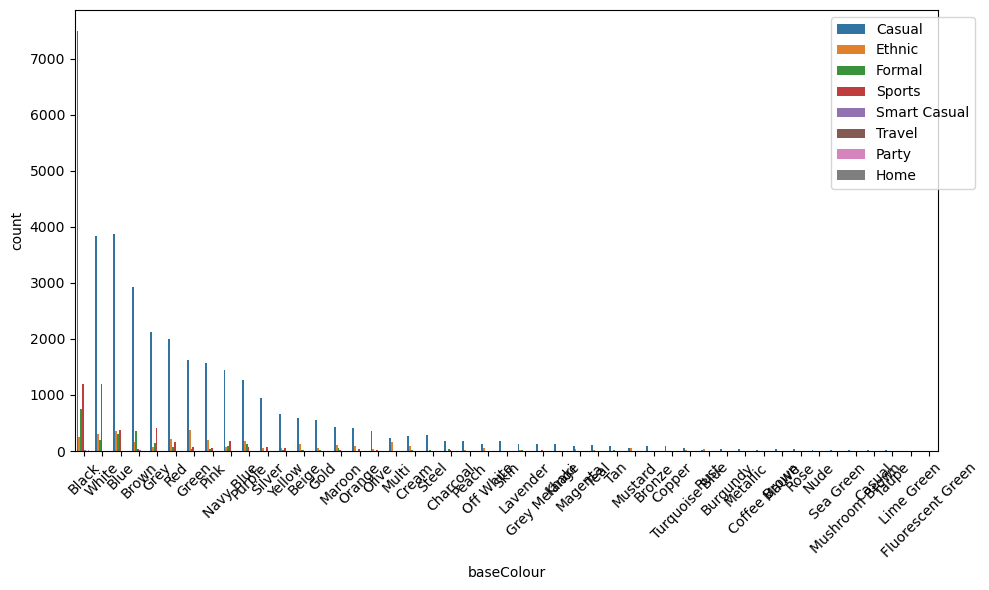

In [1272]:
# if baseColour distribution varies by usage
plt.figure(figsize=(10,6))
sns.countplot(data=df, x='baseColour', hue='usage',
              order=df['baseColour'].value_counts().index)
plt.xticks(rotation=45)
plt.legend(bbox_to_anchor=(1.05,1))
plt.tight_layout()
plt.show()

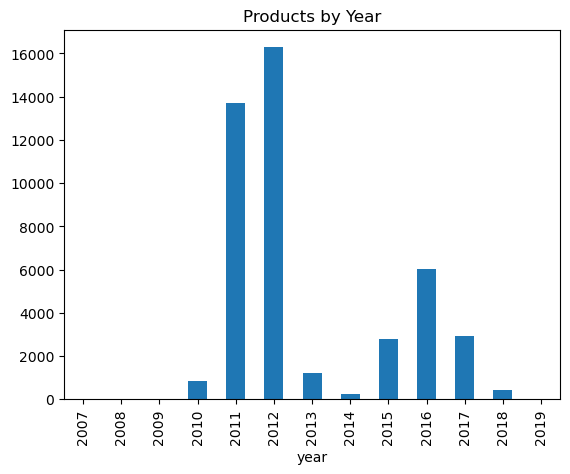

In [1274]:
df['year'].value_counts().sort_index().plot(kind='bar')
plt.title('Products by Year')
plt.show()

In [1279]:

def img_features(pid):
    img = Image.open(img_dir/f"{pid}.jpg").convert('L')
    arr = np.array(img)
    return pd.Series({'width': img.width, 'height': img.height, 'brightness': arr.mean()})

feat = df['id'].apply(img_features)
df2 = pd.concat([df, feat], axis=1)

FileNotFoundError: [Errno 2] No such file or directory: '/Users/dhanyakr/Berkeley_Self_Study/kraftwerk/Capstone_project_title_category_recommender/fashion-dataset/fashion-dataset/images/11213.jpg'

## Data Preparation

In [ ]:
# Make a copy of the dataset for preprocessing
import pandas as pd
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer

# Load the provided dataset
file_path = 'fashion-dataset/fashion-dataset/styles.csv'
data = pd.read_csv(file_path, delimiter=';')  # The file appears to use ';' as a delimiter

# Split the features into numerical and categorical
numerical_features = ['id', 'year']
target = 'articleType'
categorical_features = ['gender','masterCategory','subCategory', 'baseColour','season', 'usage','productDisplayName']


features = [col for col in data.columns if col != target]
print('Target Variable: ',target)

# Define categorical and numerical features
print(f"Numerical features: {numerical_features}")
print(f"Categorical features: {categorical_features}")

# Create a preprocessor using ColumnTransformer
transformers = []
if categorical_features:
   transformers.append(('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features))
if numerical_features:
   transformers.append(('num', StandardScaler(), numerical_features))

preprocessor = ColumnTransformer(transformers=transformers, remainder='passthrough')

# Train-test split
# Splitting the data into training and test sets

X = data[features]
y = data[target]


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Save the training and test data to CSV files
X_train.to_csv('data/X_train.csv', index=False)
X_test.to_csv('data/X_test.csv', index=False)
y_train.to_csv('data/y_train.csv', index=False)
y_test.to_csv('data/y_test.csv', index=False)

# Display the preprocessed data overview
X_train.shape, X_test.shape

## Data Modelling

In [1180]:
# Load the training and test data from the files created during the last step
# Load the training and test data from the files created during the last step
import pandas as pd

# File paths
X_train_path = 'data/X_train.csv'
X_test_path = 'data/X_test.csv'
y_train_path = 'data/y_train.csv'
y_test_path = 'data/y_test.csv'

# Load the data
X_train = pd.read_csv(X_train_path)
X_test = pd.read_csv(X_test_path)
y_train = pd.read_csv(y_train_path)
y_test = pd.read_csv(y_test_path)

# Display loaded data shapes
print("Training features shape:", X_train.shape)
print("Test features shape:", X_test.shape)
print("Training target shape:", y_train.shape)
print("Test target shape:", y_test.shape)


Training features shape: (1109, 9)
Test features shape: (278, 9)
Training target shape: (1109, 1)
Test target shape: (278, 1)


In [1182]:
#Baseline model with Logistic Regression

# Fit and transform the training data, transform the test data
X_train = preprocessor.fit_transform(X_train)
X_test = preprocessor.transform(X_test)

#Train the Logistic Regression model
model = LogisticRegression(solver='liblinear', random_state=42) 
model.fit(X_train, y_train)

/opt/anaconda3/lib/python3.12/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LogisticRegression(random_state=42, solver='liblinear')

In [1184]:
#Make predictions (probabilities for ROC AUC)
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

y_pred_proba = model.predict_proba(X_test)[:, 1] 

#Evaluate the model
y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy}")

print("\nClassification Report:")
print(classification_report(y_test, y_pred))

print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))


#Compute ROC AUC
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba) 
roc_auc = auc(fpr, tpr)

print(f'ROC AUC: {roc_auc}')

# #Plot the ROC curve
# plt.figure(figsize=(8, 6))
# plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC AUC = {roc_auc:.2f}')
# plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
# plt.xlabel('False Positive Rate')
# plt.ylabel('True Positive Rate')
# plt.title('ROC Curve for Logistic Regression')
# plt.legend(loc='lower right')
# plt.show()

Accuracy: 0.7482014388489209

Classification Report:
                       precision    recall  f1-score   support

           Baby Dolls       0.00      0.00      0.00         1
            Backpacks       1.00      1.00      1.00         1
               Bangle       1.00      1.00      1.00         1
            Bath Robe       0.00      0.00      0.00         0
                Belts       1.00      1.00      1.00         3
               Boxers       0.00      0.00      0.00         1
                  Bra       1.00      1.00      1.00         4
             Bracelet       0.14      1.00      0.25         1
               Briefs       0.40      1.00      0.57         2
                 Caps       1.00      1.00      1.00         4
         Casual Shoes       0.94      0.88      0.91        17
             Clutches       0.00      0.00      0.00         3
            Deodorant       0.00      0.00      0.00         1
              Dresses       0.67      1.00      0.80         2
 

/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/lib/python3.12/site-packages/s

ValueError: multiclass format is not supported

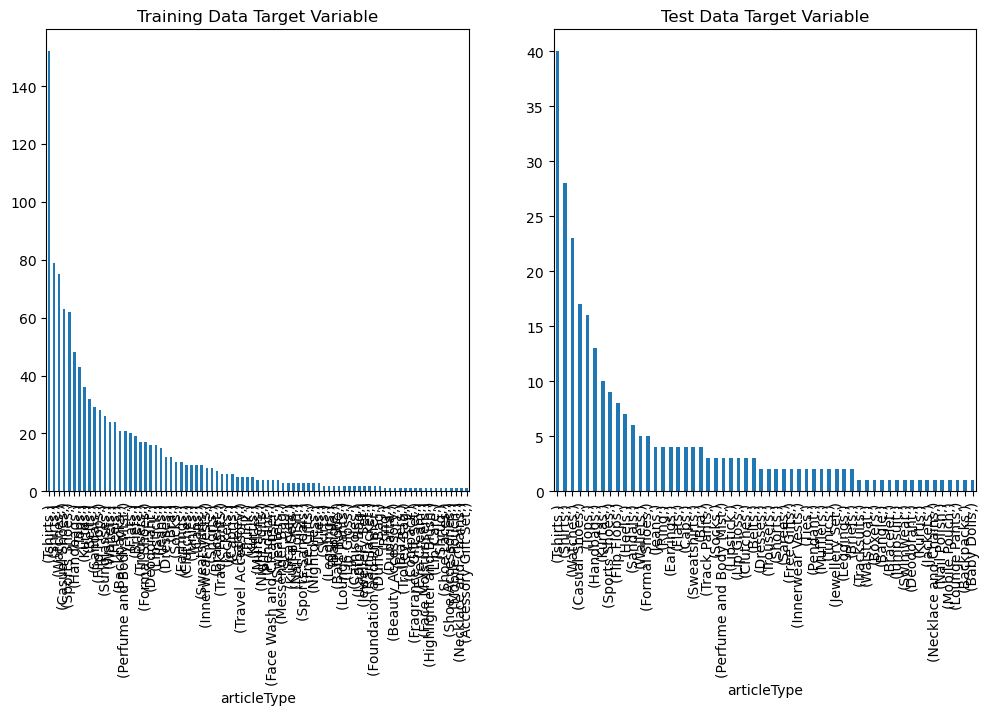

In [1186]:
# plot the bar chart of the target variable in test and training data
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1, 2, figsize=(12, 6))
y_train.value_counts().plot(kind='bar', ax=ax[0], title='Training Data Target Variable')
y_test.value_counts().plot(kind='bar', ax=ax[1], title='Test Data Target Variable')
plt.show()

### Hyper-parameter optimization

## Conclusion 